### Imports

In [1]:
import os
import time

from matplotlib import pyplot as plt
import numpy as np
import torch
import torch.nn.functional as F

### Set Hyperparameters

In [5]:
random_seed = 1
batch_size = 128
learning_rate = 0.01
num_epochs = 10
num_classes = 10

### Select Device

In [12]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Target device is {device}')

Target device is cpu


### Load and Preprocess FashionMNIST

In [6]:
from torchvision import transforms, datasets
from torch.utils.data.dataset import random_split
from torchvision.datasets import ImageFolder

data_transform = transforms.Compose(
    [
        transforms.Resize(32),
        transforms.RandomCrop((28,28)),
        transforms.ToTensor(),
        transforms.Normalize(0.5,0.5)
    ]
)

train_dataset = datasets.FashionMNIST('./FashionMNIST', train=True, transform=data_transform, download=True)
test_dataset = datasets.FashionMNIST('./FashionMNIST', train=False, transform=data_transform, download=True)

train_dataset, valid_dataset = random_split(train_dataset, lengths=[55000, 5000])

### Mini-batch Data Loaders

In [7]:
from torch.utils.data import DataLoader

train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    drop_last=True,
    num_workers=3,
    shuffle=True
)
valid_loader = DataLoader(
    dataset=valid_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)
test_loader = DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    drop_last=False,
    num_workers=3,
    shuffle=False
)

# Visualize Data

Mini_batch Dimensions: [B, C, H, W] = 
torch.Size([128, 1, 28, 28])


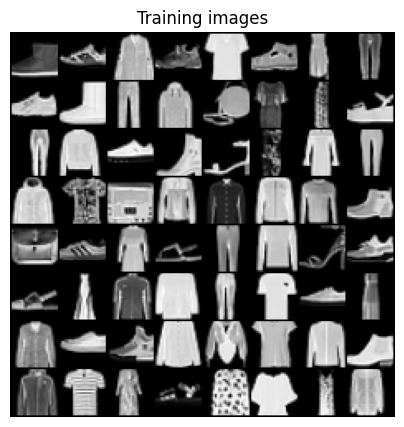

Labels = 
[[9 7 6 7 6 5 3 1]
 [7 9 1 2 8 3 3 5]
 [1 4 7 9 5 3 3 1]
 [4 0 8 6 6 4 2 9]
 [8 7 3 5 1 2 5 7]
 [5 3 4 6 1 0 7 3]
 [6 7 7 6 6 0 4 9]
 [4 0 3 5 6 6 3 4]]


In [8]:
import torchvision.utils as vutils

%matplotlib inline

im_batch = next(iter(train_loader))
print('Mini_batch Dimensions: [B, C, H, W] = ')
print(im_batch[0].shape)
plt.figure(figsize=(5, 5))
plt.title("Training images")
plt.axis("off")
plt.imshow(
    np.transpose(
        vutils.make_grid(im_batch[0][:64], nrow=8, padding=1, normalize=True), (1, 2, 0)
    )
)
plt.show()
print("Labels = " )
print(im_batch[1][:64].data.numpy().reshape(8,-1))

### CNN

In [9]:
class CNN(torch.nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.num_classes = num_classes
        self.cnn_features = torch.nn.Sequential(
            torch.nn.Conv2d(in_channels=1, out_channels=8, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
            
            torch.nn.Conv2d(in_channels=8, out_channels=16, kernel_size=3, stride=1, padding=1),
            torch.nn.ReLU(inplace=True),
            torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0),
        )
        self.fc_features = torch.nn.Sequential(
            #torch.nn.AdaptiveAvgPool2d(1),
            torch.nn.Flatten(),
            torch.nn.Linear(784, 100),
            torch.nn.ReLU(inplace=True),
            torch.nn.Linear(100, num_classes)
        )
        
    def forward(self, x):
        x = self.cnn_features(x)
        x = self.fc_features(x)
        return x

### Accuracy Metric

In [10]:
def accuracy(model, data_loader, device):
    with torch.no_grad():
        model = model.train()
        true_pred = 0
        tot_samples = 0
        for imgs, labels in data_loader:
            imgs = imgs.to(device)
            labels = labels.to(device)
            logits = model(imgs)
            _, label_pred = torch.max(logits, axis=1)
            true_pred += (label_pred==labels).sum()
            tot_samples += labels.shape[0]
        acc = (true_pred/float(tot_samples))*100
    return acc

### Training

In [13]:
torch.manual_seed(random_seed)
model = CNN(num_classes=num_classes)
model = model.to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

start = time.time()
for epoch in range(num_epochs):
    model = model.train()
    for batch_idx, (imgs, labels) in enumerate(train_loader):
        imgs = imgs.to(device)
        labels = labels.to(device)
        
        ## Forward Propagation - extract features and classify
        logits = model(imgs)
        loss = F.cross_entropy(logits, labels)
        
        #zero out the gradients
        optimizer.zero_grad()
        #estimate new gradients
        loss.backward()
        #update parameters
        optimizer.step()
        
        if not (batch_idx + 1) % 100:
            print(
                f"Epoch: {epoch + 1:03d}/{num_epochs:03d} | "
                f"Batch: {batch_idx + 1:03d}/{len(train_loader):03d} | "
                f"Loss: {loss:.4f}"
            )
    
    # Tracking the Learning Rate Scheduler
    prev_lr = optimizer.param_groups[0]["lr"]
    scheduler.step()
    current_lr = optimizer.param_groups[0]["lr"]
    print(f"Epoch: {epoch+1:03d} Learning Rate {prev_lr:.8f} -> {current_lr:.8f}")


    # Evaluate Performance after each epoch
    model = model.eval()
    tr_acc = accuracy(model, train_loader, device)
    valid_acc = accuracy(model, valid_loader, device)
    print(f"Train Accuracy: {tr_acc:0.3f}")
    print(f"Validation Accuracy: {valid_acc:0.3f}")
    print(f"Time elapsed so far: {(time.time() - start) / 60:.2f} min")
    print()

print(f"Total Train Time: {(time.time() - start) / 60:.2f} min")

Epoch: 001/010 | Batch: 100/429 | Loss: 0.6989
Epoch: 001/010 | Batch: 200/429 | Loss: 0.4838
Epoch: 001/010 | Batch: 300/429 | Loss: 0.3865
Epoch: 001/010 | Batch: 400/429 | Loss: 0.6633
Epoch: 001 Learning Rate 0.01000000 -> 0.01000000
Train Accuracy: 82.956
Validation Accuracy: 81.620
Time elapsed so far: 0.17 min
Epoch: 002/010 | Batch: 100/429 | Loss: 0.4706
Epoch: 002/010 | Batch: 200/429 | Loss: 0.3741
Epoch: 002/010 | Batch: 300/429 | Loss: 0.3445
Epoch: 002/010 | Batch: 400/429 | Loss: 0.3510
Epoch: 002 Learning Rate 0.01000000 -> 0.00500000
Train Accuracy: 85.289
Validation Accuracy: 84.680
Time elapsed so far: 0.34 min
Epoch: 003/010 | Batch: 100/429 | Loss: 0.3146
Epoch: 003/010 | Batch: 200/429 | Loss: 0.4481
Epoch: 003/010 | Batch: 300/429 | Loss: 0.4301
Epoch: 003/010 | Batch: 400/429 | Loss: 0.3324
Epoch: 003 Learning Rate 0.00500000 -> 0.00500000
Train Accuracy: 87.407
Validation Accuracy: 86.340
Time elapsed so far: 0.50 min
Epoch: 004/010 | Batch: 100/429 | Loss: 0.2

KeyboardInterrupt: 

### Final Evaluation

In [ ]:
model = model.eval()
ts_acc = accuracy(model, test_loader, device)
print(f"Test Accuracy: {ts_acc:0.3f}")